In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

import common

In [4]:
date_set_path = "../temp_sets_100/"

# labevents

## Read samples

In [5]:
labevents_df = common.read_csv_no_rowid(date_set_path + "labevents.csv")

## Data preproces

In [6]:
# Drop useless colums
labevents_df.drop(['subject_id', 'valuenum', 'flag'], axis=1, inplace=True)

### Process missing values

In [7]:
# Drop some null value
labevents_df.dropna(subset=['hadm_id'], inplace=True, axis=0)
labevents_df['hadm_id'] = labevents_df['hadm_id'].astype(np.int64)

In [8]:
common.nan_count(labevents_df)

Total columns: 5
Total rows: 65503
--------------
hadm_id         0
itemid          0
charttime       0
value           5
valueuom     7441
dtype: int64


In [9]:
labevents_df['value'].fillna(value='Na', inplace=True)

### Set the column types

In [10]:
labevents_df.dtypes

hadm_id       int64
itemid        int64
charttime    object
value        object
valueuom     object
dtype: object

In [11]:
labevents_df['charttime'] = pd.to_datetime(labevents_df['charttime'])

In [12]:
labevents_df.dtypes

hadm_id               int64
itemid                int64
charttime    datetime64[ns]
value                object
valueuom             object
dtype: object

### Process time value

In [13]:
admissions_df = common.read_csv_no_rowid(date_set_path+"admissions.csv")

In [14]:
hadm_intime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
hadm_intime_df['admittime'] = pd.to_datetime(hadm_intime_df['admittime'])

In [15]:
labevents_mid_df = pd.merge(left=labevents_df, right=hadm_intime_df, how='left', on=['hadm_id'])

In [16]:
labevents_mid_df.dtypes

hadm_id               int64
itemid                int64
charttime    datetime64[ns]
value                object
valueuom             object
admittime    datetime64[ns]
dtype: object

In [17]:
labevents_mid_df['charttime'] = labevents_mid_df.apply(common.time_process, args=('admittime', 'charttime'), axis=1)
labevents_mid_df['charttime'] = labevents_mid_df['charttime'].astype(np.int64)

In [73]:
labevents_df = labevents_mid_df.drop(['hadm_id', 'admittime'], axis=1)

##  Build Network

---

### CTGAN

In [75]:
from sdv.tabular import CTGAN
from sdv.tabular import GaussianCopula
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations

In [76]:
fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

In [77]:
labevents_constraints = [fixed_item_value_constraint]

In [78]:
model = CTGAN(
    constraints=labevents_constraints, 
    cuda=True, 
    verbose=True)

In [79]:
len(labevents_df)

44069

In [80]:
train_data = labevents_df.sample(n=2000)
model.fit(train_data)

Epoch 1, Loss G:  7.1438,Loss D: -0.0030
Epoch 2, Loss G:  7.1169,Loss D: -0.0076
Epoch 3, Loss G:  7.0650,Loss D: -0.0104
Epoch 4, Loss G:  7.0619,Loss D: -0.0178
Epoch 5, Loss G:  7.0658,Loss D: -0.0091
Epoch 6, Loss G:  7.0392,Loss D:  0.0127
Epoch 7, Loss G:  7.0355,Loss D:  0.0024
Epoch 8, Loss G:  7.0374,Loss D: -0.0079
Epoch 9, Loss G:  6.9916,Loss D: -0.0007
Epoch 10, Loss G:  7.0168,Loss D:  0.0047
Epoch 11, Loss G:  6.9618,Loss D:  0.0129
Epoch 12, Loss G:  6.9743,Loss D: -0.0058
Epoch 13, Loss G:  6.9819,Loss D:  0.0170
Epoch 14, Loss G:  7.0244,Loss D: -0.0048
Epoch 15, Loss G:  6.9495,Loss D: -0.0006
Epoch 16, Loss G:  6.9344,Loss D:  0.0234
Epoch 17, Loss G:  6.9391,Loss D:  0.0253
Epoch 18, Loss G:  6.9015,Loss D: -0.0034
Epoch 19, Loss G:  6.9643,Loss D: -0.0040
Epoch 20, Loss G:  6.9435,Loss D: -0.0012
Epoch 21, Loss G:  6.9112,Loss D: -0.0046
Epoch 22, Loss G:  6.8984,Loss D: -0.0003
Epoch 23, Loss G:  6.8877,Loss D:  0.0237
Epoch 24, Loss G:  6.8502,Loss D:  0.0071
E

In [81]:
# model.save(date_set_path + "100_models/" + "labevents_model.pkl")

import cloudpickle

with open(date_set_path + "100_models/" + "labevents_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [82]:
sample = model.sample(num_rows=10000)

Sampling rows: 100%|██████████| 10000/10000 [00:00<00:00, 16598.99it/s]


In [84]:
def format_values(df):
    if is_number(df['value']):
        return round(float(df['value']), 2)
    else:
        return df['value']


In [85]:
sample['value'] = sample.apply(format_values, axis=1)
sample['value'] = sample['value'].astype(str)

In [86]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.9246008790957898

In [87]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.13475231087482883

In [88]:
evaluate(sample, train_data)

0.569835364412904

<AxesSubplot:>

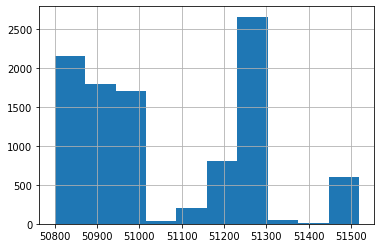

In [91]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

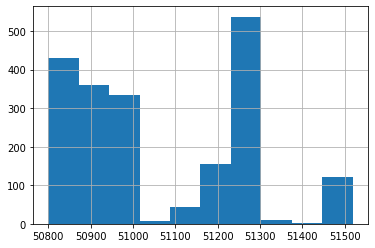

In [92]:
train_data.sort_values('itemid')['itemid'].hist()